In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import time
import numpy as np
import pandas as pd
from uuid import uuid4
from typing import Dict, Union
import os

In [2]:
def moveTo(obj, device):
    """
    obj: the python object ot move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(o, device) for o in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(o, device) for o in obj)
    elif isinstance(obj, set):
        return set(moveTo(o, device) for o in obj)
    elif isinstance(obj, dict):
        to_ret = dict()
        for k, v in obj.items():
            to_ret[moveTo(k, device)] = moveTo(v, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

In [42]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix=""):
    # init empty variables
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    # loop over the batchs
    for inputs, labels in data_loader:
        # move x, y to correct device
        inputs = moveTo(inputs, device=device)
        labels = moveTo(labels, device=device)

        # estimate
        y_hat = model(inputs)

        # compute loss, backpropagate and apply gradients if needed
        loss = loss_func(y_hat, labels)
        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # store the results
        running_loss.append(loss.item())
        if score_funcs is not None and len(score_funcs) > 1 and isinstance(labels, torch.Tensor):
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
        
    end = time.time()

    # clean results to compute metrics under sklearn standards
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)
    
    results[prefix + ' loss'].append(np.mean(running_loss))
    if score_funcs is not None:
        for name, score_func in score_funcs.items():
            try:
                results[prefix + " " + name].append( score_func(y_true, y_pred) )
            except:
                results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoc

def save_model(
    model: nn.Module,
    checkpoint_file: str,
    optimizer: nn.Module,
    true_epoch: int,
    results: Dict,
    model_file_name: str = None
):
    # check if the folder for models exists
    folder_path = "checkpoints"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # save the model checkpoint
    file_name = uuid4().hex + '_' + checkpoint_file
    if model_file_name is not None:
        file_name = model_file_name
    torch.save({
        'epoch': true_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'results' : results
        }, os.path.join(folder_path, file_name))

def train_simple_network(
        model, 
        loss_func,
        train_loader,
        test_loader=None,
        score_funcs=None,
        device='cpu',
        epochs=50,
        checkpoint_file=None,
        prev_results=None,
        checkpoint_dict=None,
        checkpoint_every_x=1
    ):
    # init tracking metrics
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )
    total_train_time = 0
    if prev_results is None:
        results = {}
        for item in to_track:
            results[item] = []
    else:
        results = prev_results

    # initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    if checkpoint_dict is not None and 'optimizer_state_dict' in checkpoint_dict.keys():
        optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])

    # start training loop
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        # pass the model throught a epoch
        model = model.train()
        total_train_time += run_epoch(
            model, 
            optimizer, 
            train_loader, 
            loss_func, 
            device, 
            results, 
            score_funcs, 
            prefix="train", 
        )
    
        # grab more results from the last epoch
        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        # test the model in validation
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test")

        # save the model checkpoint after the epoch
        true_epoch = len(results['epoch']) - 1 # useful when model and optimizer loaded
        if checkpoint_file is not None and (true_epoch % checkpoint_every_x) == 0:
            save_model(
                model=model,
                checkpoint_file=checkpoint_file,
                optimizer=optimizer,
                true_epoch=true_epoch,
                results=results
            )
    
    # save the last model
    if checkpoint_file is not None:
        save_model(
                model=model,
                checkpoint_file=checkpoint_file,
                optimizer=optimizer,
                true_epoch=true_epoch,
                results=results,
                model_file_name='last.pt'
            )

    return pd.DataFrame.from_dict(results)

### 1

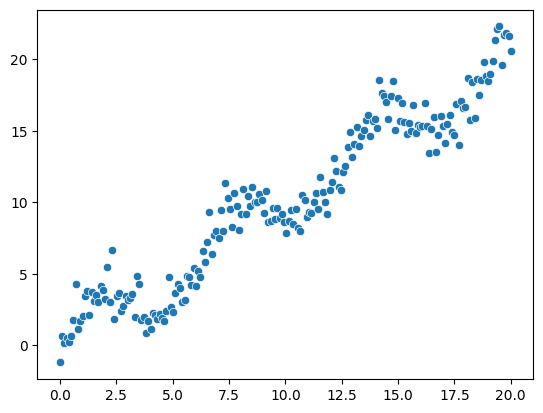

In [4]:
# datos simulados para un problema de regresion
X = np.linspace(0, 20 , num=200).reshape(-1, 1)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape).reshape(-1, 1)
sns.scatterplot(x=X[:,0], y=y[:, 0])

class Simple1DRegressionDataset(Dataset):
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index, :], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.float32)    
        )
    
    def __len__(self):
        return self.X.shape[0]

training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
class StandardScale1DRegressionDataset(Dataset):
    def __init__(self, X, y):
        super(StandardScale1DRegressionDataset, self).__init__()
        self.X = X
        self.y = self.standard_scale(y)
    
    @staticmethod  # probably not a staticmethod in real life 
    def standard_scale(x):
        scaler = StandardScaler()
        scaler.fit(x)
        return scaler.transform(x)

    def __getitem__(self, index):
        return (
            torch.tensor(self.X[index, :], dtype=torch.float32),
            torch.tensor(self.y[index], dtype=torch.float32)    
        )
    
    def __len__(self):
        return self.X.shape[0]

standard_training_loader = DataLoader(StandardScale1DRegressionDataset(X, y), shuffle=True)

In [7]:
# without scaling
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

result = train_simple_network(
    model,
    loss_func,
    training_loader,
)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
# with scaling
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

result_st = train_simple_network(
    model,
    loss_func,
    standard_training_loader,
)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
result.tail()

,epoch,total time,train loss
45,45,0.753546,3.504186
46,46,0.769354,3.408611
47,47,0.785876,3.438417
48,48,0.801542,3.581873
49,49,0.817082,3.699392


In [10]:
result_st.tail()

,epoch,total time,train loss
45,45,0.742807,0.102017
46,46,0.758658,0.102128
47,47,0.774211,0.103583
48,48,0.790290,0.096879
49,49,0.805595,0.095644


### 2

<Axes: >

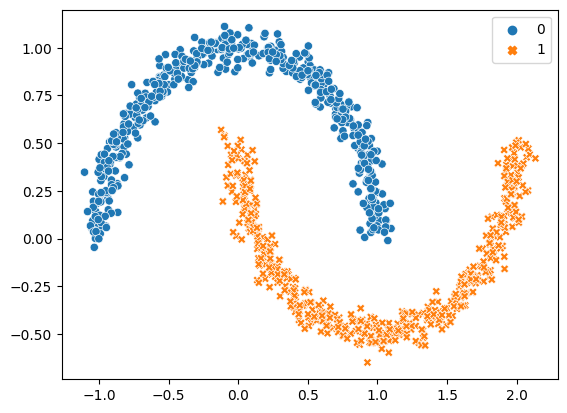

In [11]:
X, y = make_moons(n_samples=1000, noise=0.05)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y)

In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [39]:
X_train, y_train = make_moons(n_samples=800, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)
loss_func = nn.CrossEntropyLoss()
result_pd = train_simple_network(
    model,
    loss_func,
    training_loader,
    epochs=10,
    test_loader=testing_loader,
    checkpoint_file='model.pt',
    score_funcs={'Acc': accuracy_score, 'F1': f1_score, 'ROC_AUC': roc_auc_score},
    checkpoint_every_x = 5
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
result_pd

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1,train ROC_AUC,test ROC_AUC
0,0,0.116467,0.586062,0.528355,0.71250,0.755,0.748908,0.767773,0.71250,0.755
1,1,0.223906,0.484702,0.469289,0.78250,0.795,0.793349,0.798030,0.78250,0.795
2,2,0.332773,0.446298,0.443657,0.79875,0.800,0.801968,0.800000,0.79875,0.800
3,3,0.444498,0.429104,0.428910,0.80750,0.800,0.809406,0.800000,0.80750,0.800
4,4,0.557334,0.419120,0.419327,0.81250,0.800,0.814815,0.797980,0.81250,0.800


### 3

In [15]:
def resume_simple_network(
    checkpoint_file: str, 
    model: torch.nn.Module, 
    loss_func: nn.Module,
    train_loader: DataLoader,
    test_loader: Union[DataLoader, None],
    score_funcs: Dict,
    device: str = 'cpu',
    epochs: int = 50
):
    # loading information
    checkpoint_dict = torch.load(checkpoint_file, map_location='cpu')
    model.load_state_dict(checkpoint_dict['model_state_dict'])
    # get the remainder epochs
    rem_epochs = epochs - checkpoint_dict['epoch'] - 1
    if rem_epochs < 1:
        raise ValueError(f"Total number of epochs already done {checkpoint_dict['epoch'] + 1}")
    

    results = train_simple_network(
        model=model,
        loss_func=loss_func,
        train_loader=train_loader,
        test_loader=test_loader,
        score_funcs=score_funcs,
        device=device,
        epochs=rem_epochs,
        checkpoint_file=checkpoint_file,
        prev_results=checkpoint_dict['results']
    )

    results['epoch'] = np.arange(0, len(results))

    return results

In [16]:
new_results_pd = resume_simple_network(
    checkpoint_file='model.pt',
    model=model,
    loss_func=loss_func,
    train_loader=training_loader,
    test_loader=testing_loader,
    score_funcs={'Acc': accuracy_score, 'F1': f1_score, 'ROC_AUC': roc_auc_score},
    device='cpu',
    epochs=30
)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

In [17]:
new_results_pd

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1,train ROC_AUC,test ROC_AUC
0,0,0.116467,0.586062,0.528355,0.71250,0.755,0.748908,0.767773,0.71250,0.755
1,1,0.223906,0.484702,0.469289,0.78250,0.795,0.793349,0.798030,0.78250,0.795
2,2,0.332773,0.446298,0.443657,0.79875,0.800,0.801968,0.800000,0.79875,0.800
3,3,0.444498,0.429104,0.428910,0.80750,0.800,0.809406,0.800000,0.80750,0.800
4,4,0.557334,0.419120,0.419327,0.81250,0.800,0.814815,0.797980,0.81250,0.800
5,5,0.117976,0.412995,0.412683,0.81500,0.805,0.815461,0.802030,0.81500,0.805
6,6,0.227397,0.408931,0.407716,0.82250,0.810,0.823383,0.806122,0.82250,0.810
7,7,0.337862,0.406008,0.403694,0.82375,0.820,0.824408,0.820000,0.82375,0.820
8,8,0.448473,0.404048,0.400596,0.83000,0.825,0.830424,0.825871,0.83000,0.825
9,9,0.556702,0.402502,0.398317,0.82750,0.815,0.828358,0.814070,0.82750,0.815


### 5

In [74]:
X_train, y_train = make_moons(n_samples=800, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

hiddens = [1, 2, 5, 10, 15, 20]
results_dict = {}
for hide in hiddens:
    print(f'Procesing {hide} layers')
    layers = [nn.Linear(2, 30), nn.Tanh()]
    for i in range(hide):
        layers.extend([nn.Linear(30, 30), nn.ReLU()])
    layers.append(nn.Linear(30, 2))
    model = nn.Sequential(*layers)
    loss_func = nn.CrossEntropyLoss()
    results_dict[str(hide)] = train_simple_network(
        model,
        loss_func,
        training_loader,
        epochs=100,
        test_loader=testing_loader,
        checkpoint_file=None,
        score_funcs={'Acc': accuracy_score, 'F1': f1_score, 'ROC_AUC': roc_auc_score},
        device='cpu'
    )

Procesing 1 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 2 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 5 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 10 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 15 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Procesing 20 layers


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [75]:
accs = pd.DataFrame(index=list(range(100)))
for res in results_dict:
    accs[res + '_test Acc'] = results_dict[res]['test Acc']

<Axes: >

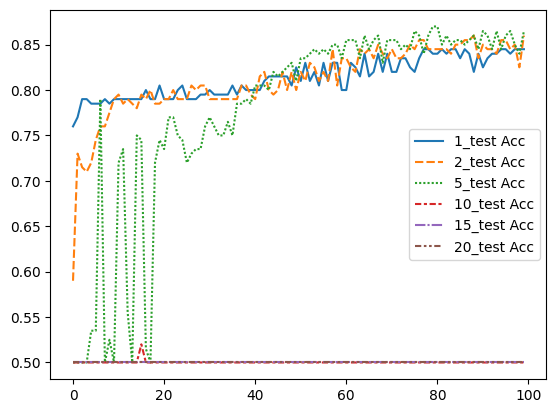

In [76]:
sns.lineplot(data=accs)

In [77]:
accs.tail(10)

,1_test Acc,2_test Acc,5_test Acc,10_test Acc,15_test Acc,20_test Acc
90,0.825,0.850,0.865,0.5,0.5,0.5
91,0.835,0.845,0.860,0.5,0.5,0.5
92,0.840,0.845,0.845,0.5,0.5,0.5
93,0.840,0.840,0.865,0.5,0.5,0.5
94,0.845,0.855,0.845,0.5,0.5,0.5
95,0.845,0.855,0.860,0.5,0.5,0.5
96,0.840,0.845,0.865,0.5,0.5,0.5
97,0.845,0.850,0.850,0.5,0.5,0.5
98,0.845,0.825,0.840,0.5,0.5,0.5
99,0.845,0.860,0.865,0.5,0.5,0.5


### 6

In [78]:
X_train, y_train = make_moons(n_samples=800, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

sizes = [30, 50, 100, 512, 1024]
results_dict = {}
for size in sizes:
    print(f'Procesing {size} neurons')
    model = nn.Sequential(
        nn.Linear(2, size),
        nn.Tanh(),
        nn.Linear(size, size),
        nn.Tanh(),
        nn.Linear(size, 2)
    )
    loss_func = nn.CrossEntropyLoss()
    results_dict[str(size)] = train_simple_network(
        model,
        loss_func,
        training_loader,
        epochs=25,
        test_loader=testing_loader,
        checkpoint_file=None,
        score_funcs={'Acc': accuracy_score, 'F1': f1_score, 'ROC_AUC': roc_auc_score},
        device='cpu'
    )

Procesing 30 layers


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 50 layers


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 100 layers


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 512 layers


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 1024 layers


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

<Axes: >

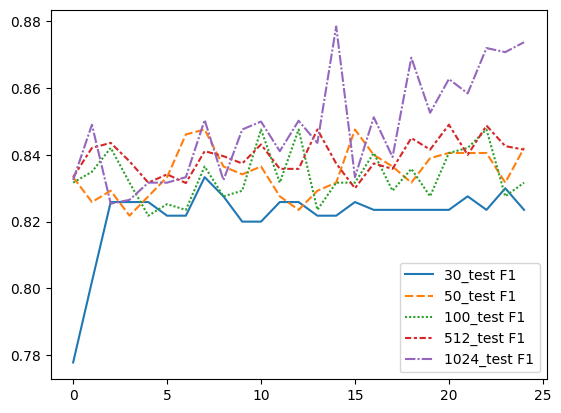

In [88]:
accs = pd.DataFrame(index=list(range(25)))
for res in results_dict:
    accs[res + '_test F1'] = results_dict[res]['test F1']

sns.lineplot(data=accs)

In [89]:
accs.tail(10)

,30_test F1,50_test F1,100_test F1,512_test F1,1024_test F1
15,0.825871,0.847619,0.831683,0.830000,0.833333
16,0.823529,0.840000,0.840580,0.837438,0.851282
17,0.823529,0.836538,0.829268,0.835821,0.839378
18,0.823529,0.831683,0.835821,0.845070,0.869159
19,0.823529,0.839024,0.827586,0.841584,0.852632
20,0.823529,0.840580,0.840580,0.849057,0.862745
21,0.827586,0.840580,0.842105,0.840000,0.858447
22,0.823529,0.840580,0.847619,0.848780,0.872038
23,0.830000,0.831683,0.827586,0.842640,0.870813
24,0.823529,0.842105,0.831683,0.841584,0.873786


In [87]:
accs.tail(10)

,30_test ROC_AUC,50_test ROC_AUC,100_test ROC_AUC,512_test ROC_AUC,1024_test ROC_AUC
15,0.825,0.840,0.830,0.830,0.840
16,0.820,0.840,0.835,0.835,0.855
17,0.820,0.830,0.825,0.835,0.845
18,0.820,0.830,0.835,0.835,0.860
19,0.820,0.835,0.825,0.840,0.860
20,0.820,0.835,0.835,0.840,0.860
21,0.825,0.835,0.835,0.840,0.845
22,0.820,0.835,0.840,0.845,0.865
23,0.830,0.830,0.825,0.845,0.865
24,0.820,0.835,0.830,0.840,0.870


# todo

tengo malo el calculo del ROC_AUC o algo esta pasando, porque esta dando el mismo resultado que el accuracy.

### 8

In [92]:
X_train, y_train = make_moons(n_samples=800, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)

batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256]
results_dict = {}
for batch_size in batch_sizes:
    training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testing_loader = DataLoader(test_dataset, batch_size=batch_size)
    print(f'Procesing {batch_size} batch size')
    model = nn.Sequential(
        nn.Linear(2, 30),
        nn.Tanh(),
        nn.Linear(30, 30),
        nn.Tanh(),
        nn.Linear(30, 2)
    )
    loss_func = nn.CrossEntropyLoss()
    results_dict[str(batch_size)] = train_simple_network(
        model,
        loss_func,
        training_loader,
        epochs=25,
        test_loader=testing_loader,
        checkpoint_file=None,
        score_funcs={'Acc': accuracy_score, 'F1': f1_score, 'ROC_AUC': roc_auc_score},
        device='cpu'
    )

Procesing 2 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 4 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 8 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 16 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 32 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 64 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 128 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Procesing 256 batch size


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

<Axes: >

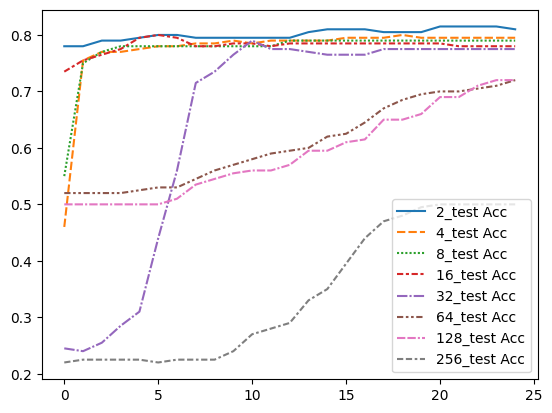

In [93]:
accs = pd.DataFrame(index=list(range(25)))
for res in results_dict:
    accs[res + '_test Acc'] = results_dict[res]['test Acc']

sns.lineplot(data=accs)